## Reproduce the result of *SmoothGrad: removing noise by adding noise*

Link to the paper: https://arxiv.org/pdf/1706.03825.pdf

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.autograd import grad,Variable

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

#------------------------------
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image

import os,math,random
os.environ['CUDA_VISIBLE_DEVICES']='1'

torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
random.seed(123)

# load names of imagenet 1000 classes
import json,pprint
json_data=open('imagenet_class_index.json').read()
data = json.loads(json_data)
classes = [data[str(k)][1] for k in range(1000)]

mean,std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

class Saliency(object):
    def __init__(self,model):
        self.model = model
    def getMask(self,img,pred_label=None):
        pass
    def getSmoothMask(self,img,stddev=0.15,nsamples=20):
        stddev *= img.max()-img.min()
        total_grad = torch.zeros(img.shape)
        noise = torch.zeros(img.shape)
        for i in range(nsamples):
            img_plus_noise = img + noise.zero_().normal_(0,stddev) 
            grad = self.getMask(img_plus_noise)
            total_grad += grad * grad
        total_grad /= nsamples
        return total_grad

class VallinaSaliency(Saliency):
    def getMask(self,img,pred_label=None):
        self.model.eval()
        self.model.zero_grad()
        x = Variable(img.unsqueeze(0).cuda(),requires_grad=True)
        y = self.model(x)
        p = F.softmax(y)
        if pred_label is None:
            _,pred_label = torch.max(p,1)
            pred_label = pred_label.data
        pk = p[0][pred_label]
        pk.backward()
        
        mask3d = x.grad.data[0].cpu()
        return mask3d

## Helper function

In [35]:
def PIL2tensor(img):
    img = img.resize((224,224),Image.BILINEAR)
    img = np.asarray(img,dtype=np.float32)/255
    img = (img - mean)/std
    img = torch.from_numpy(img.transpose([2,0,1])).float()
    return img

def infer(model,img0):
    model.eval()
    img = img0.clone()
    if img.ndimension()==3:
        img = img.unsqueeze_(0)
    img = Variable(img.cuda())
    p = model(img).data
    p = p.squeeze().cpu().numpy()
    return p

def visualize_image_gray_scale(img3d,percentile=99):
    if str(type(img3d)).find('torch')!= -1:
        img3d = img3d.numpy()
        img3d = img3d.transpose([1,2,0])
    img2d = np.sum(np.abs(img3d),2)
    
    vmax  = np.percentile(img2d,percentile)
    vmin  = img2d.min()
    img2d = np.clip((img2d-vmin)/(vmax-vmin),0,1)
    return img2d


def test_image(model,img,smooth=False,nsamples=20,stddev=0.15):
    saliency = VallinaSaliency(model)
    if not smooth: 
        mask3d = saliency.getMask(img)
    else:
        mask3d = saliency.getSmoothMask(img,nsamples=nsamples,stddev=stddev)
    mask2d = visualize_image_gray_scale(mask3d,percentile=99)

    prob = nn.Sequential(model,nn.Softmax()).cuda()
    prob_pred = infer(prob,img)
    label = prob_pred.argmax()

    plt.figure(figsize=(10,3));
    plt.subplot(1,3,1); imshow(img,classes[label]);
    plt.subplot(1,3,2); plt.imshow(mask2d);
    plt.subplot(1,3,3); plt.plot(prob_pred,'o');

In [58]:
model = models.resnet50(pretrained=True).cuda()

## Caveat
- Must use *eval model*, the forward propogation would change the batch statistics in *train model*

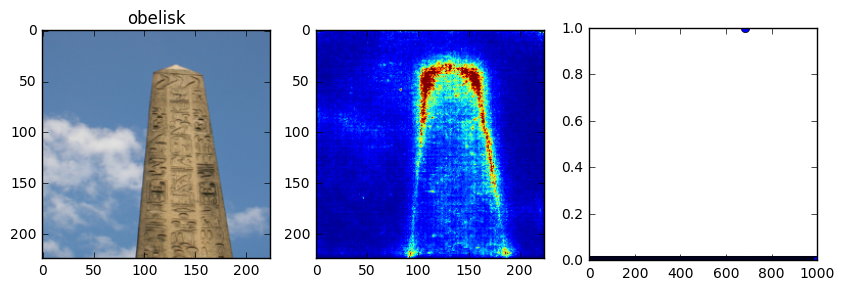

In [45]:
img = Image.open('./images/obelisk.png')
img = PIL2tensor(img)
test_image(model,img,smooth=True,nsamples=50,stddev=0.2)

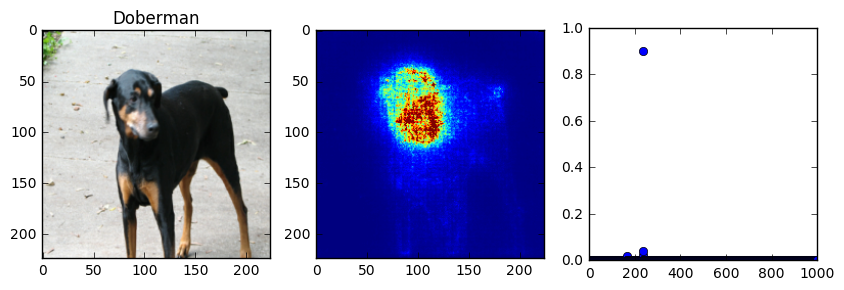

In [44]:
img = Image.open('./images/doberman.png')
img = PIL2tensor(img)
test_image(model,img,smooth=True,nsamples=50,stddev=0.2)

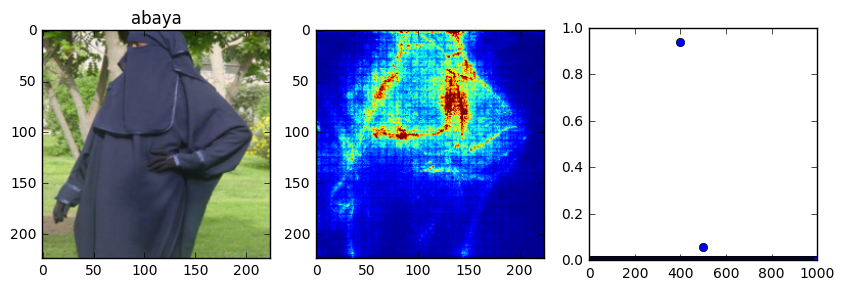

In [57]:
img = Image.open('./images/5.png')
img = PIL2tensor(img)
test_image(model,img,smooth=True,nsamples=100,stddev=0.2)

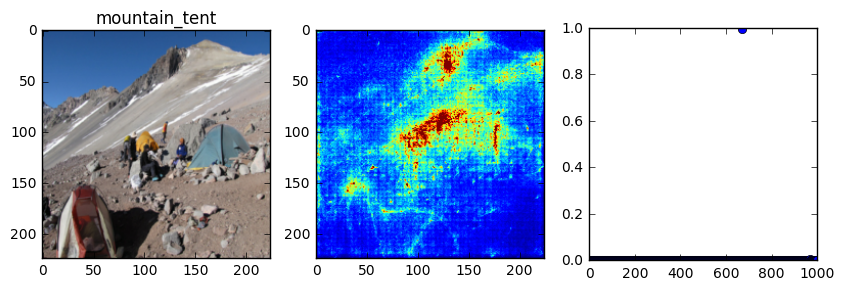

In [55]:
img = Image.open('./images/16.png')
img = PIL2tensor(img)
test_image(model,img,smooth=True,nsamples=100,stddev=0.2)